## 傅立叶变换
快速傅立叶，numpy

图像的频率是表征图像中灰度变化剧烈程度的指标，是灰度在平面空间上的梯度。因此图像的傅立叶变换表示了（灰度）分布的剧烈程度

白色：变换明显；黑色：变换缓慢。
没有谱中心处理：四角低频中心高频；谱中心化：四角高频中心低频。

refer：https://blog.csdn.net/fengyingv/article/details/109630535

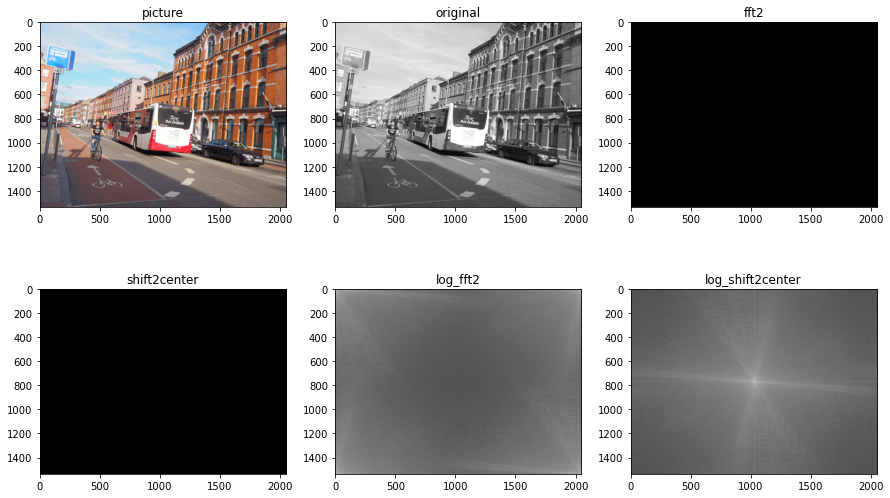

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2
import math

plt.figure(figsize=(15, 9))

img = plt.imread(path)
plt.subplot(231),plt.imshow(img),plt.title('picture')
 
#根据公式转成灰度图
img = 0.2126 * img[:,:,0] + 0.7152 * img[:,:,1] + 0.0722 * img[:,:,2]
 
#显示灰度图
plt.subplot(232),plt.imshow(img,'gray'),plt.title('original')
 
#进行傅立叶变换，并显示结果
fft2 = np.fft.fft2(img)
plt.subplot(233),plt.imshow(np.abs(fft2),'gray'),plt.title('fft2')
 
#将图像变换的原点移动到频域矩形的中心，并显示效果
shift2center = np.fft.fftshift(fft2)
plt.subplot(234),plt.imshow(np.abs(shift2center),'gray'),plt.title('shift2center')
 
#对傅立叶变换的结果进行对数变换，并显示效果
log_fft2 = np.log(1 + np.abs(fft2))
plt.subplot(235),plt.imshow(log_fft2,'gray'),plt.title('log_fft2')
 
#对中心化后的结果进行对数变换，并显示结果
log_shift2center = np.log(1 + np.abs(shift2center))
plt.subplot(236),plt.imshow(log_shift2center,'gray'),plt.title('log_shift2center')
plt.show()

## 运动模糊模型

构建运动模糊模型
        
图像f(x,y)在图像面上移动并且图像f(x,y)除移动外不随时间变化。令x0(t)和y0(t)分别代表位移的x分量和y分量，那么在快门开启的时间T内，胶片上某点的总曝光量是图像在移动过程中一系列相应像素的亮度对该点作用之总和。也就是说，运动模糊图像是由同一图像在产生距离延迟后与原图像想叠加而成。如果快门开启与关闭的时间忽略不计，则有：
$g(x,y)=\int_{0}^{T}f[x-x_{0}(t)), y-y_{0}(t))]dt$



下面我们描述一下该模型函数motion_process(image_size,motion_angle)，它包含两个参数：图像的尺寸大小image_size以及运动的角度motion_angle。

例如，当运动位移为9、运动角度为45度时，则该模型函数的构建过程如下：

首先是创建与图像同等大小的全0矩阵，然后找到全0矩阵的中心行数center_position，再计算出运动角度的tan值与cot值，算出运动的偏移量offset。
再令α≤45°时，$PSF[int(center_position+offset),int(center_position-offset)]=1$
α≥45°时，$PSF[int(center_position-offset),int(center_position+offset)]=1$
则该模型对应的图像如下图所示：
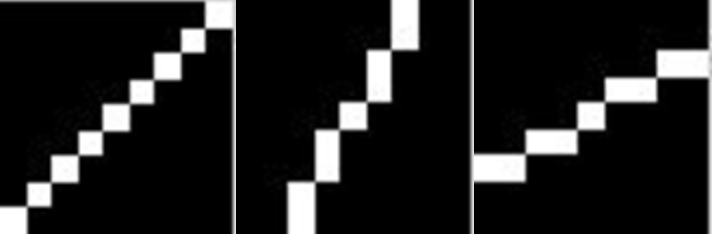

运动位移为9，运动角度分别为45°、30°、60°时，运动模糊模型对应的图像

In [3]:
# 仿真运动模糊
def motion_process(image_size,motion_angle):
    PSF = np.zeros(image_size)
    print(f'image_size:{image_size}')
    center_position=(image_size[0]-1)/2
    print(f'center_position:{center_position}')
 
    slope_tan=math.tan(motion_angle*math.pi/180)
    slope_cot=1/slope_tan
    if slope_tan<=1:
        for i in range(15):
            offset=round(i*slope_tan) #((center_position-i)*slope_tan)
            PSF[int(center_position+offset),int(center_position-offset)]=1
        return PSF / PSF.sum() #对点扩散函数进行归一化亮度
    else:
        for i in range(15):
            offset=round(i*slope_cot)
            PSF[int(center_position-offset),int(center_position+offset)]=1
        return PSF / PSF.sum()

# 对图片进行运动模糊
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)# 进行二维数组的傅里叶变换
    PSF_fft = fft.fft2(PSF)+ eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred

In [14]:
# 生成卷积核和锚点
def genaratePsf(length, angle):
    half = length/2
    EPS = np.finfo(float).eps
    alpha = (angle - math.floor(angle / 180) * 180) / 180 * math.pi
    cosalpha = math.cos(alpha)
    sinalpha = math.sin(alpha)
    if cosalpha < 0:
        xsign = -1
    elif angle == 90:
        xsign = 0
    else:
        xsign = 1
    psfwdt = 1;
    # 模糊核大小
    sx = int(math.fabs(length * cosalpha + psfwdt * xsign - length * EPS))
    sy = int(math.fabs(length * sinalpha + psfwdt - length * EPS))
    psf1 = np.zeros((sy, sx))
    # psf1是左上角的权值较大，越往右下角权值越小的核。
    # 这时运动像是从右下角到左上角移动
    for i in range(0, sy):
        for j in range(0, sx):
            psf1[i][j] = i * math.fabs(cosalpha) - j * sinalpha
            rad = math.sqrt(i * i + j * j)
            if rad >= half and math.fabs(psf1[i][j]) <= psfwdt:
                temp = half - math.fabs((j + psf1[i][j] * sinalpha) / cosalpha)
                psf1[i][j] = math.sqrt(psf1[i][j] * psf1[i][j] + temp * temp)
            psf1[i][j] = psfwdt + EPS - math.fabs(psf1[i][j]);
            if psf1[i][j] < 0:
                psf1[i][j] = 0
    # 运动方向是往左上运动，锚点在（0，0）
    anchor = (0, 0)
    # 运动方向是往右上角移动，锚点一个在右上角    #同时，左右翻转核函数，使得越靠近锚点，权值越大
    if angle < 90 and angle > 0:
        psf1 = np.fliplr(psf1)
        anchor = (psf1.shape[1] - 1, 0)
    elif angle > -90 and angle < 0:  # 同理：往右下角移动
        psf1 = np.flipud(psf1)
        psf1 = np.fliplr(psf1)
        anchor = (psf1.shape[1] - 1, psf1.shape[0] - 1)
    elif anchor < -90:  # 同理：往左下角移动
        psf1 = np.flipud(psf1)
        anchor = (0, psf1.shape[0] - 1)
    psf1 = psf1 / psf1.sum()
    return psf1, anchor


## 逆滤波
https://blog.csdn.net/bingbingxie1/article/details/79398601
IMG_2594.JPG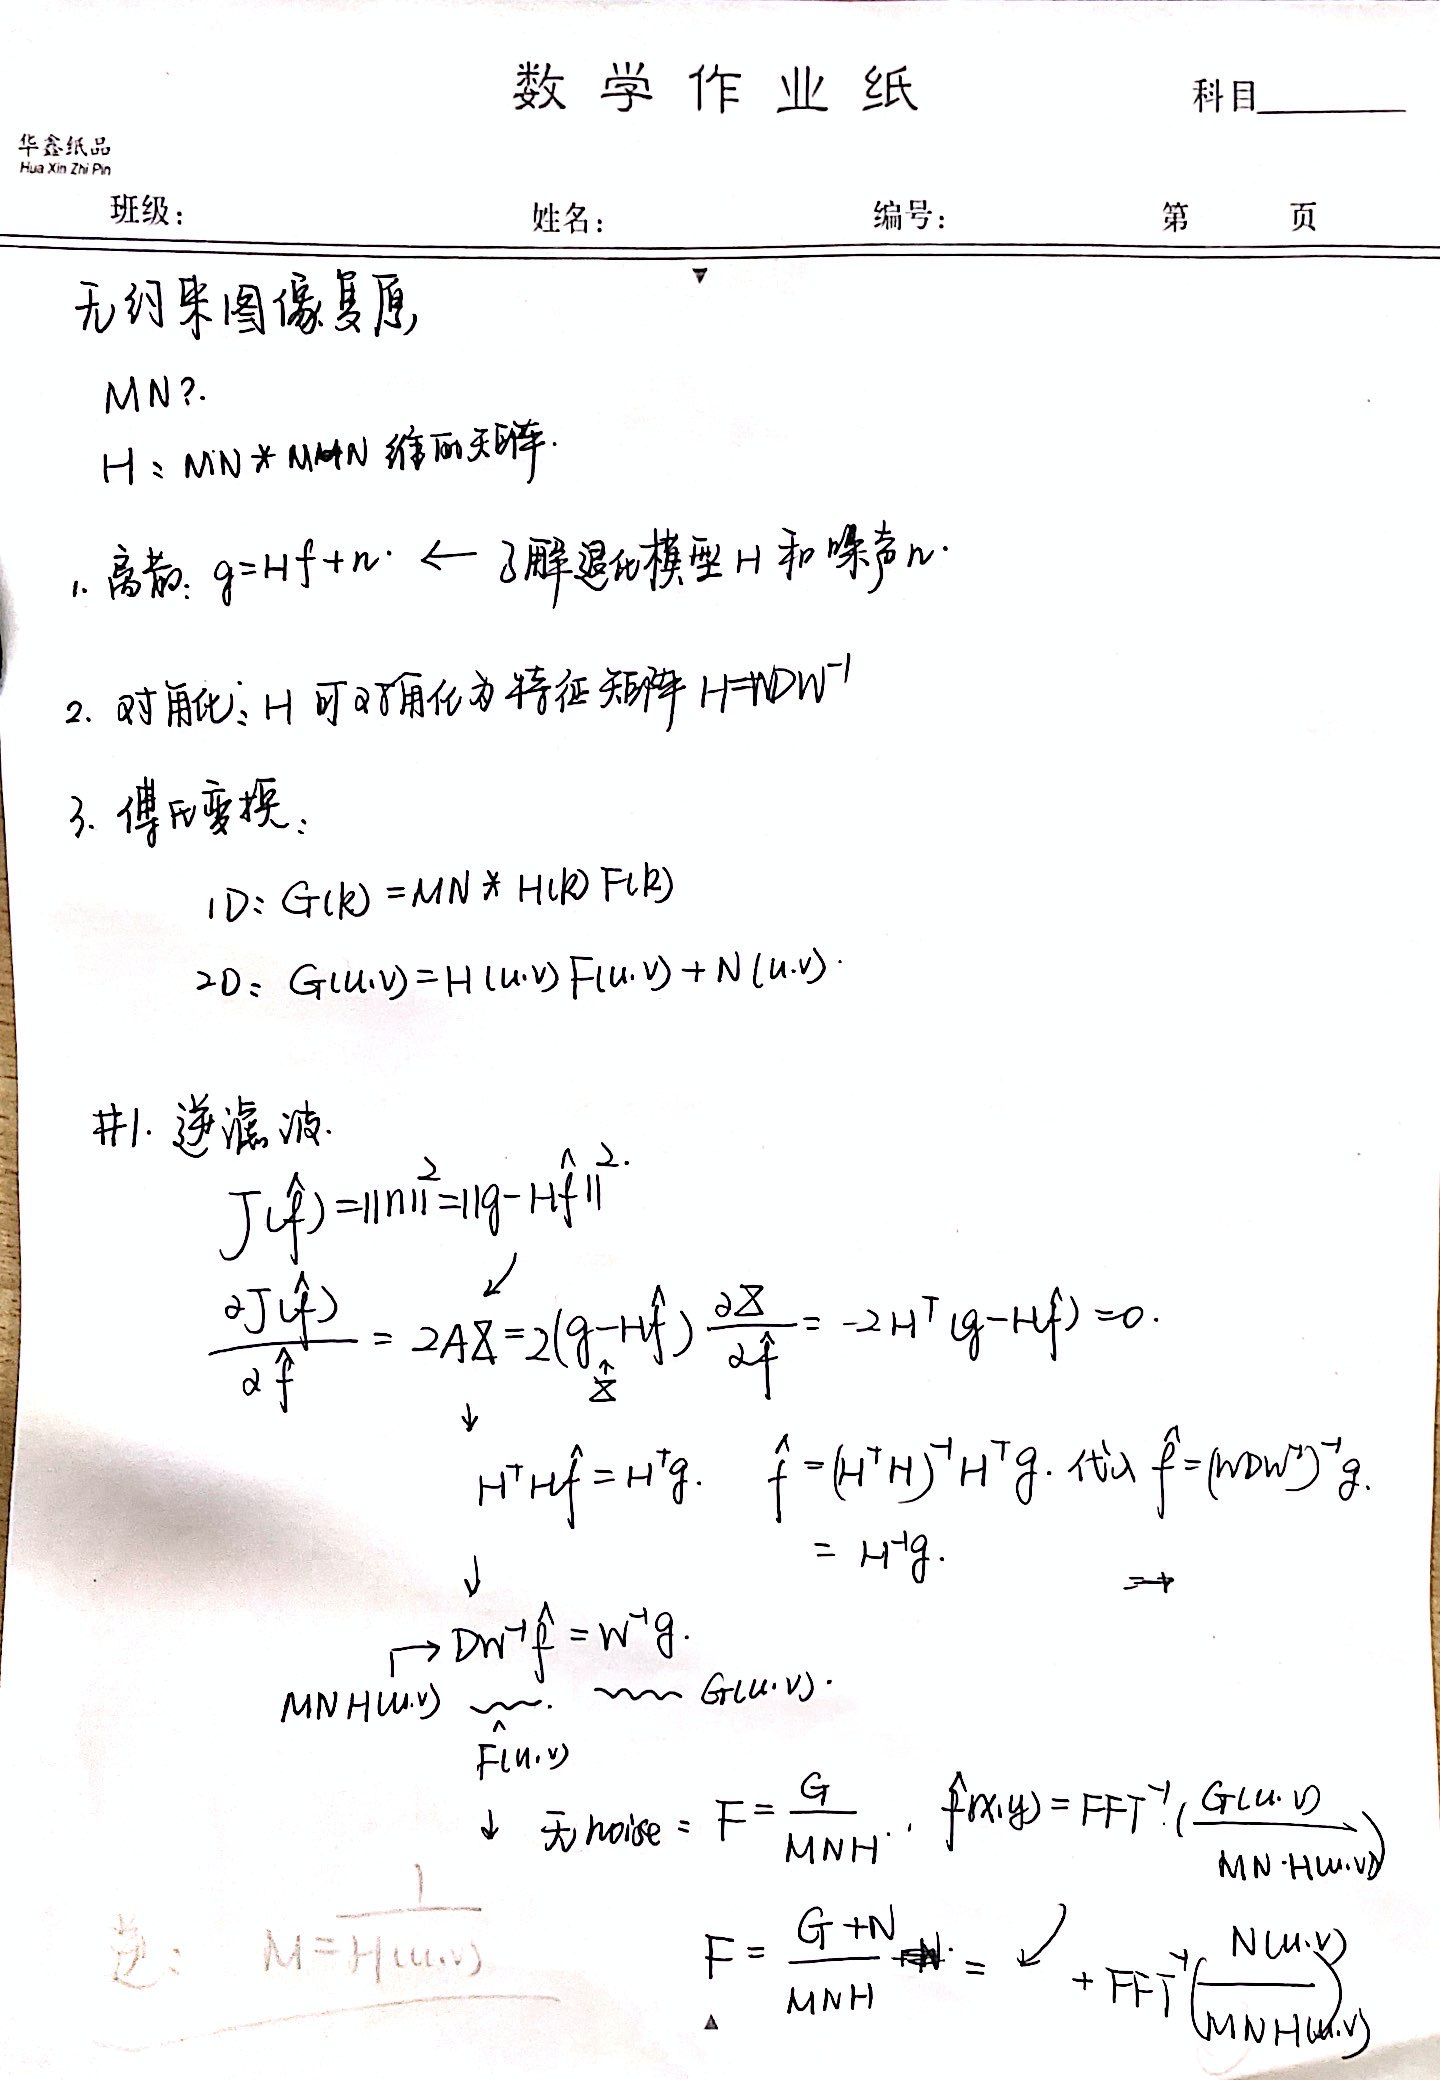

In [4]:
def inverse(input, PSF, eps):  # 逆滤波
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps # 噪声功率，这是已知的，考虑epsilon
    result = fft.ifft2(input_fft / PSF_fft) # 计算F(u,v)的傅里叶反变换
    result = np.abs(fft.fftshift(result))
    return result

## 维纳滤波


In [5]:
def wiener(input,PSF,eps,K=0.01):  # 维纳滤波，K=0.01
    input_fft=fft.fft2(input)
    PSF_fft=fft.fft2(PSF) +eps
    PSF_fft_1=np.conj(PSF_fft) /(np.abs(PSF_fft)**2 + K)
    result=fft.ifft2(input_fft * PSF_fft_1)
    result=np.abs(fft.fftshift(result))
    return result


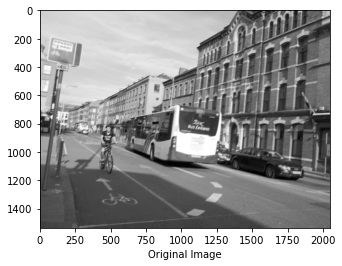

In [19]:
path = '/Users/panyining/Desktop/ireland.JPG'
image = cv2.imread(path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

kernel,anchor=genaratePsf(20,40)
motion_blur=cv2.filter2D(image,-1,kernel,anchor=anchor)
cv2.imwrite('test.jpg', motion_blur)
plt.figure(1)
plt.xlabel("Original Image")
plt.gray()
plt.imshow(motion_blur)  # 显示原图像


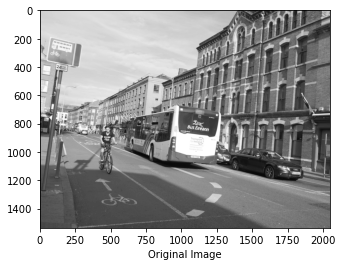

<Figure size 432x288 with 0 Axes>

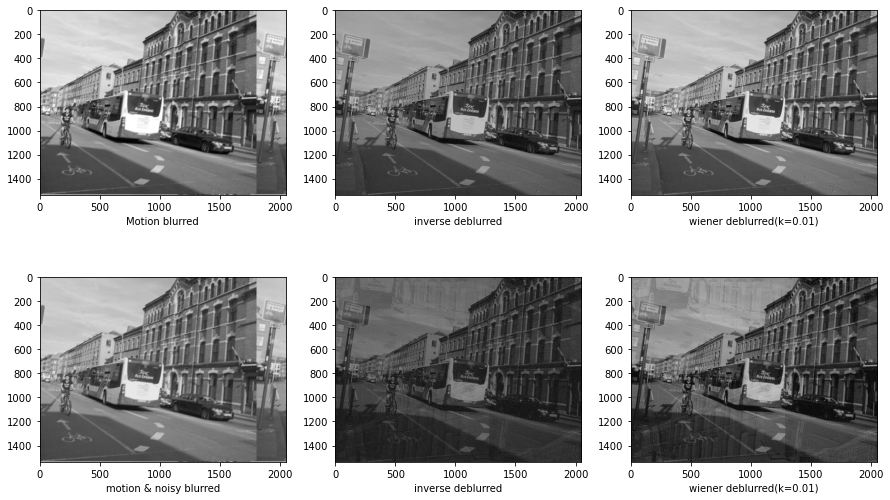

In [21]:
path = '/Users/panyining/Desktop/ireland.JPG'
image = cv2.imread(path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
img_h = image.shape[0]
img_w = image.shape[1]
plt.figure(1)
plt.xlabel("Original Image")
plt.gray()
plt.imshow(image)  # 显示原图像

plt.figure(2)
plt.figure(figsize=(15, 9))
plt.gray()
# 进行运动模糊处理
# PSF = motion_process((img_h,img_w), 60)
# blurred = np.abs(make_blurred(image, PSF, 1e-2))
kernel,anchor=genaratePsf(20,40)
motion_blur=cv2.filter2D(image,-1,kernel,anchor=anchor)
cv2.imwrite('./result/blurred.jpg', motion_blur)

plt.subplot(231)
plt.xlabel("Motion blurred")
plt.imshow(blurred)
 
result_i = inverse(blurred, PSF, 1e-3) # 逆滤波
cv2.imwrite('./result/inverse_deblurred.jpg', result_i)
plt.subplot(232)
plt.xlabel("inverse deblurred")
plt.imshow(result_i)
 
result_w = wiener(blurred,PSF,1e-3)  # 维纳滤波
cv2.imwrite('./result/wiener_deblurred.jpg', result_w)
plt.subplot(233)
plt.xlabel("wiener deblurred(k=0.01)")
plt.imshow(result_w)
 
blurred_noisy = blurred + 0.1 * blurred.std() * \
   np.random.standard_normal(blurred.shape) # 添加噪声,standard_normal产生随机的函数
plt.subplot(234)
plt.xlabel("motion & noisy blurred")
plt.imshow(blurred_noisy)  # 显示添加噪声且运动模糊的图像
 
result_in = inverse(blurred_noisy, PSF, 0.2+1e-3) # 对添加噪声的图像进行逆滤波
cv2.imwrite('./result/inverse_noised_deblurred.jpg', result_in) 
plt.subplot(235)
plt.xlabel("inverse deblurred")
plt.imshow(result_in)
 
result_wn = wiener(blurred_noisy,PSF,0.2+1e-3)   # 对添加噪声的图像进行维纳滤波
cv2.imwrite('./result/wiener_noised_deblurred.jpg', result_wn) 
plt.subplot(236)
plt.xlabel("wiener deblurred(k=0.01)")
plt.imshow(result_wn)
 
plt.show()


# 评价函数
## Visually：主观鉴别、最符合人视觉感官的评价，但无法标准化。
## Visibility of Errors
计算图像degrade后的质量，即比较degrade后的图像与真实图像（distortion-free）之间的差剖面，即可视误差，通过 visibility of errors 评价图像质量。
### MSE
均方差，两点之间数值差异。

In [22]:
def mse(img1, img2):
    mse = np.mean( (img1/255. - img2/255.) ** 2)
    return mse

In [24]:
mse_in = mse(image, result_in)
mse_wn = mse(image, result_wn)
print(f'the MSE of inverse: {mse_in}')
print(f'the MSE of wiener: {mse_wn}')

the MSE of inverse: 0.05014422166814427
the MSE of wiener: 0.018432496990242724


### PSNR
峰值信噪比，即峰值信号的能量与噪声的平均能量之比，通常表示的时候取 log 变成分贝（dB），由于 MSE 为真实图像与含噪图像之差的能量均值，而两者的差即为噪声，因此 PSNR 即峰值信号能量与 MSE 之比。定义式如下：$$PSNR = 10\times\log_{10} \frac{MaxValue^2}{MSE} $$ 
其中$MaxValue^2$表示为存储最大位数$2^{bits}-1$

PSNR指标越高，说明图像质量越好。

In [25]:
def psnr1(img1, img2):
    mse = np.mean((img1/1.0 - img2/1.0) ** 2 )
    if mse < 1.0e-10:
        return 100
    return 10 * math.log10(255.0**2/mse)
 
def psnr2(img1, img2):
    mse = np.mean( (img1/255. - img2/255.) ** 2 )
    if mse < 1.0e-10:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [26]:
psnr_in = psnr1(image, result_in)
psnr_wn = psnr1(image, result_wn)

print(f'the PSNR of inverse: {psnr_in}')
print(f'the PSNR of wiener: {psnr_wn}')

the PSNR of inverse: 12.99779105359895
the PSNR of wiener: 17.34415828338798


In [27]:
psnr_i = psnr2(image, result_i)
psnr_w = psnr2(image, result_w)
print(f'the PSNR of inverse: {psnr_i}')
print(f'the PSNR of wiener: {psnr_w}')

the PSNR of inverse: 20.975427654482523
the PSNR of wiener: 30.060955132498997


## SSIM
由于基于差剖面的简单计算不符合人类视觉系统（Human Visual System，HVS）的评价结果，因此需要对评价方式进行重新考量。
从自然图像高度结构化的特征出发，设计新的assessment:相比于之前估计 perceived errors，该思路估计感知结构信息的变化 perceived changes in structural information variation。

从之前实验看到，MSE的表现有差别，PSNR表现类似的result_in和result_wn，实际从人的主管感觉来说差别是很大的。这里SSIM中，认为contrast的stretch，以及均值的偏移，即整体上明暗变化，基本上并不会影响人类对图像的内容的理解。因此应该让这样的图片得到的质量值更高。原因在于我们可以把original information近乎完全的恢复出来，只需要做pixel-wise的映射即可。而像比如blur，JPEG compression等，许多结构信息已经永久丢失了，因此应该相似度低。

SSIM的基本思路是，通过一下三个方面来对两幅图像的相似性进行评估，即

1. luminance，亮度
2. contrast，对比度
3. structure，结构

SSIM.png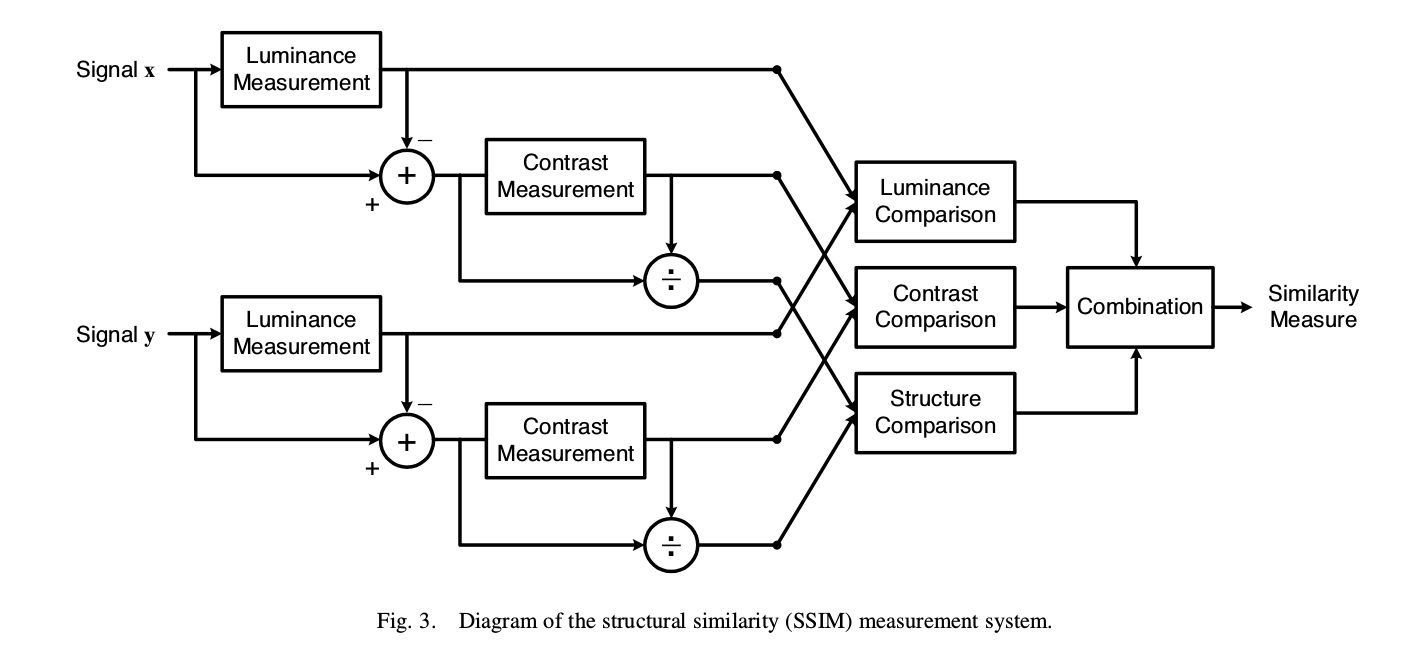

In [28]:
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
 
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
#     2D gaussian mask - should give the same result as MATLAB's
#     fspecial('gaussian',[shape],[sigma])

    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h
 
def filter2(x, kernel, mode='same'):
    return convolve2d(x, np.rot90(kernel, 2), mode=mode)
 
def compute_ssim(im1, im2, k1=0.01, k2=0.03, win_size=11, L=255):
 
    if not im1.shape == im2.shape:
        raise ValueError("Input Imagees must have the same dimensions")
    if len(im1.shape) > 2:
        raise ValueError("Please input the images with 1 channel")

    M, N = im1.shape
    C1 = (k1*L)**2
    C2 = (k2*L)**2
    window = matlab_style_gauss2D(shape=(win_size,win_size), sigma=1.5)
    window = window/np.sum(np.sum(window))

    if im1.dtype == np.uint8:
        im1 = np.double(im1)
    if im2.dtype == np.uint8:
        im2 = np.double(im2)

    mu1 = filter2(im1, window, 'valid')
    mu2 = filter2(im2, window, 'valid')
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = filter2(im1*im1, window, 'valid') - mu1_sq
    sigma2_sq = filter2(im2*im2, window, 'valid') - mu2_sq
    sigmal2 = filter2(im1*im2, window, 'valid') - mu1_mu2

    ssim_map = ((2*mu1_mu2+C1) * (2*sigmal2+C2)) / ((mu1_sq+mu2_sq+C1) * (sigma1_sq+sigma2_sq+C2))

    return np.mean(np.mean(ssim_map))


In [29]:
compute_ssim(image, result_w)

0.8927095575969591

方法2: 使用skimage自带的metrics.structural_similarity函数

In [30]:
import cv2
from skimage import metrics

ssim_i = metrics.structural_similarity(image, result_i)
ssim_w = metrics.structural_similarity(image, result_w)

# ssim_in = measure.compare_ssim(image, result_in)
# ssim_wn = measure.compare_ssim(image, result_wn)
print(ssim_i, ssim_w)

/Users/panyining/anaconda3/envs/torch2/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  after removing the cwd from sys.path.
/Users/panyining/anaconda3/envs/torch2/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


0.37539214163685825 0.8886091974140963


## 最小二乘法约束
https://blog.csdn.net/w
sp_1138886114/article/details/95024180
约束最小二乘方滤波（Constrained Least Squares Filtering，aka Tikhonov filtration,Tikhonov regularization）核心是H对噪声的敏感性问题。减少噪声敏感新问题的一种方法是以平滑度量的最佳复原为基础的，建立下列约束条件：



In [31]:
def CLSF(blurred,PF,gamma = 0.05):
    outheight, outwidth = blurred.shape[:2]
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    PF_kernel = psf2otf(kernel,[outheight, outwidth])
    IF_noisy = fft.fft2(blurred)

    numerator = np.conj(PF)
    denominator = PF**2 + gamma*(PF_kernel**2)
    CLSF_deblurred = fft.ifft2(numerator* IF_noisy/ denominator)
    CLSF_deblurred = np.real(CLSF_deblurred)
    return CLSF_deblurred

def normal(array):
    array = np.where(array < 0,  0, array)
    array = np.where(array > 255, 255, array)
    array = array.astype(np.int16)
    return array


In [33]:
# psf2osf
import numpy as np
import math
import cv2

def circShift(array,K):
    height,width = array.shape
    if len(array.shape)>=2 and height*width>=4:
        if type(K) ==int and abs(K)<height:
            updownA = array[:-K, :]
            mainArray = array[-K:,:]
            flip_matrix =  np.concatenate((mainArray,updownA),axis=0)
        elif type(K) ==tuple or type(K) ==list and abs(K[0])<height and abs(K[1])<width:
            updownA = array[:-K[0], :]
            mainArray = array[-K[0]:, :]
            temp = np.concatenate((mainArray, updownA), axis=0)

            leftrightA = temp[:, :-K[1]]
            tempArray = temp[:, -K[1]:]
            flip_matrix =  np.concatenate((tempArray,leftrightA),axis=1)
        else:
            print("移动的数组必须小于待移动的数组长与宽")
            flip_matrix = None
    else:
        print('传入数据错误或移动的Numpy.ndarray数组维度至少为(2，2)')
        flip_matrix = None
    return flip_matrix

def psf2otf(psf, outsize):
    if np.count_nonzero(psf) > 1:
        outheight, outwidth = outsize
        psfheight, psfwidth = psf.shape[:2]
        paddheight, paddwidth = outheight - psfheight, outwidth - psfwidth
        print('paddheight, paddwidth',paddheight, paddwidth)
        print('paddheight//2, paddwidth//2', paddheight//2, paddwidth//2)
        if paddheight==0 and paddwidth==0:
            otf = np.fft.fft2(psf)
            otf = np.real(otf),0
        else:
            otf0 = cv2.copyMakeBorder(psf, paddheight // 2, paddheight // 2,
                                     paddwidth // 2, paddwidth // 2,cv2.BORDER_CONSTANT)
            K = (-(math.floor(otf0.shape[0])//2),-(math.floor(otf0.shape[1])//2))
            otf = circShift(otf0,K)
            otfComplex = np.fft.fft2(otf)
            otf = np.real(otfComplex)
    else:
        print('该 ndrray 数组不需要转换')
        otf =  None
    return otf

paddheight, paddwidth 1521 2033
paddheight//2, paddwidth//2 760 1016
paddheight, paddwidth 1532 2044
paddheight//2, paddwidth//2 766 1022
paddheight, paddwidth 1532 2044
paddheight//2, paddwidth//2 766 1022
paddheight, paddwidth 1521 2033
paddheight//2, paddwidth//2 760 1016
paddheight, paddwidth 1532 2044
paddheight//2, paddwidth//2 766 1022
paddheight, paddwidth 1532 2044
paddheight//2, paddwidth//2 766 1022
paddheight, paddwidth 1521 2033
paddheight//2, paddwidth//2 760 1016
paddheight, paddwidth 1532 2044
paddheight//2, paddwidth//2 766 1022
paddheight, paddwidth 1532 2044
paddheight//2, paddwidth//2 766 1022


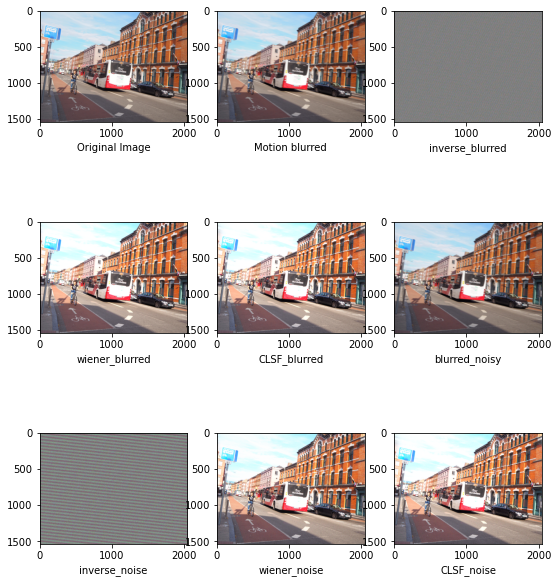

In [48]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
import cv2
# from temp_004 import psf2otf


def motion_blur(gray, degree=7, angle=60):
    gray = np.array(gray)
    M = cv2.getRotationMatrix2D((round(degree / 2), round(degree / 2)), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    PSF = motion_blur_kernel / degree

    blurred = cv2.filter2D(gray, -1, PSF)
    blurred = cv2.normalize(blurred,None, 0, 255, cv2.NORM_MINMAX)
    blurred = np.array(blurred, dtype=np.uint8)
    return blurred,PSF


def inverse(blurred, PF):
    IF_fft = fft.fft2(blurred)
    result = fft.ifft2(IF_fft / PF)
    result = np.real(result)
    return result

def wiener(blurred, PF, SNR=0.01):       # 维纳滤波，K=0.01
    IF_fft = fft.fft2(blurred)
    G_f = np.conj(PF) / (np.abs(PF) ** 2 + SNR)
    result = fft.ifft2(IF_fft * G_f)
    result = np.real(result)
    return result

def CLSF(blurred,PF,gamma = 0.05):
    outheight, outwidth = blurred.shape[:2]
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    PF_kernel = psf2otf(kernel,[outheight, outwidth])
    IF_noisy = fft.fft2(blurred)

    numerator = np.conj(PF)
    denominator = PF**2 + gamma*(PF_kernel**2)
    CLSF_deblurred = fft.ifft2(numerator* IF_noisy/ denominator)
    CLSF_deblurred = np.real(CLSF_deblurred)
    return CLSF_deblurred

def normal(array):
    array = np.where(array < 0,  0, array)
    array = np.where(array > 255, 255, array)
    array = array.astype(np.int16)
    return array


def main(gray):
    channel = []
    img_H, img_W = gray.shape[:2]
    blurred,PSF = motion_blur(gray, degree=15, angle=30)      # 进行运动模糊处理
    PF = psf2otf(PSF, [img_H, img_W])
#     print(img_H, img_W)
    
#     print(PF.shape)
    W, H = PF.shape
    dim = (H, W)
    blurred = cv2.resize(blurred, dim, interpolation = cv2.INTER_AREA)
    inverse_blurred =normal(inverse(blurred, PF))             # 逆滤波
    wiener_blurred = normal(wiener(blurred, PF))              # 维纳滤波
    CLSF_blurred = normal(CLSF(blurred, PF))                  # 约束最小二乘方滤波

    blurred_noisy = blurred + 0.1 * blurred.std() * \
                    np.random.standard_normal(blurred.shape)  # 添加噪声

    inverse_noise = normal(inverse(blurred_noisy, PF))        # 添加噪声-逆滤波
    wiener_noise = normal(wiener(blurred_noisy, PF))          # 添加噪声-维纳滤波
    CLSF_noise = normal(CLSF(blurred_noisy, PF))              # 添加噪声-约束最小二乘方滤波
#     print('CLSF_deblurred',CLSF_blurred)
    channel.append((blurred,inverse_blurred,wiener_blurred,CLSF_blurred,
                    normal(blurred_noisy),inverse_noise,wiener_noise,CLSF_noise))
    return channel


if __name__ == '__main__':
    image = cv2.imread(path)
    b_gray, g_gray, r_gray = cv2.split(image.copy())

    Result = []
    for gray in [b_gray, g_gray, r_gray]:
        channel = main(gray)
        Result.append(channel)

    blurred = cv2.merge([Result[0][0][0], Result[1][0][0], Result[2][0][0]])
    inverse_blurred = cv2.merge([Result[0][0][1], Result[1][0][1], Result[2][0][1]])
    wiener_blurred = cv2.merge([Result[0][0][2], Result[1][0][2], Result[2][0][2]])
    CLSF_blurred = cv2.merge([Result[0][0][3], Result[1][0][3], Result[2][0][3]])
    blurred_noise = cv2.merge([Result[0][0][4], Result[1][0][4], Result[2][0][4]])
    inverse_noise = cv2.merge([Result[0][0][5], Result[1][0][5], Result[2][0][5]])
    wiener_noise = cv2.merge([Result[0][0][6], Result[1][0][6], Result[2][0][6]])
    CLSF_noise = cv2.merge([Result[0][0][7], Result[1][0][7], Result[2][0][7]])
    cv2.imwrite('./result/blurred_RGB.jpg', blurred) 
    cv2.imwrite('./result/inverse_blurred_RGB.jpg', inverse_blurred) 
    cv2.imwrite('./result/wiener_blurred_RGB.jpg', wiener_blurred) 
    cv2.imwrite('./result/CLSF_blurred_RGB.jpg', CLSF_blurred) 
    cv2.imwrite('./result/blurred_noise_RGB.jpg', blurred_noise) 
    cv2.imwrite('./result/inverse_noise_RGB.jpg', inverse_noise) 
    cv2.imwrite('./result/wiener_noise_RGB.jpg', wiener_noise) 
    cv2.imwrite('./result/CLSF_noise_RGB.jpg', CLSF_noise) 



    #========= 可视化 ==========
    plt.figure(figsize=(9, 11))
    plt.gray()
    imgNames = {"Original Image":image,
                "Motion blurred":blurred,
                "inverse_blurred":inverse_blurred,
                "wiener_blurred": wiener_blurred,
                "CLSF_blurred": CLSF_blurred,
                'blurred_noisy': blurred_noisy,
                "inverse_noise":inverse_noise,
                "wiener_noise":wiener_noise,
                "CLSF_noise":CLSF_noise
                }
    for i,(key,imgName) in enumerate(imgNames.items()):
        plt.subplot(331+i)
        plt.xlabel(key)
        plt.imshow(np.flip(imgName, axis=2))
    plt.show()



其实这个方法是一个很好的想法，将图像的能量作为评价图像平滑程度的度量，尽可能的将其平滑。设噪声的能量是一个定值，使用拉普拉斯未定系数法，将其进行迭代，然后解开。 这种方法有了很多的变种，包括很著名的TV(Total Variation，全变分)模型，这个我之后的博文会讲到。
在这里，使用本方法的目的是，减少噪音对于逆滤波的影响。表达式如下所示。

这个滤波器，可以消除很严重的噪声，并且复原图像。将实验用图像的噪声的方差提升到0.2，再进行滤波，可以得到如下结果。

## 超分辨率重建
https://www.cnblogs.com/hellcat/p/10481282.html